In [ ]:
#############################################################
# Compile `main.cu` to `file.exe`
# Commented out because we don't want to run it all the time
#############################################################
!nvcc -w functions.cu main.cu -o file

In [1]:
#############################################################
# Load python dependencies
# If package cannot be resolved from pylance, reload the interpreter
#############################################################
import numpy as np
import matplotlib.pyplot as plt
import utils
import os.path

# Generate detuning
todo: distribution functions
read into detuning.dat

In [ ]:
#############################################################
# Generate and write detuning data to file
#############################################################
# Write 1D numpy array to file
detuning_values_1d = utils.gen_same_pop(2, 1000, None)
print("Detuning data:", detuning_values_1d)
np.savetxt("Detuning.dat", detuning_values_1d, delimiter="\t")

# Example: write 2D numpy array to file
# values_2d = np.array([
#     [10.0, 20.0, 40.0],
#     [10.0, 20.0, 50.0],
#     [10.0, 20.0, 60.0]
# ])
# np.savetxt("values_2d.dat", values_2d, delimiter="\t")

# Run simulation

To run a single system, use terminal: 

         k  n_tot theta,phi g gamma chi kap t_end t_num handle

file.exe 20 100000 0.5 0.0 1.6 0.0 0.0 160 0.5 600000 k20N5_0.5_0_kappa160

## Suggested file naming convention:
k{num_ens}N{order of magnitude of n_total}_{theta_phi}_{other params}

E.g., k5N5_1_0_kappa160

The below block of code is useful for running multiple jobs

In [3]:
#############################################################
# Test 3: for initial cases, "single use", tested utils.crit1
#############################################################
N_tot = 1000000
num_ens = 3
theta_0 = 1
phi_0 = 0.0
coup_a_0 = 1.0
gamma_a_0 = 0.0
chi_a_0 = 0.0
kappa_c_0 = 100.0
t_max = 0.2
t_num = 60000
run = 0
det_dict = {}
handle_list = []
delta_min = 0
delta_crit = delta_min
delta_max = 600
detuning_max = [0, -delta_max, delta_max]

# Run
np.savetxt("Detuning.dat", detuning_max, delimiter="\t")
params = f'{num_ens} {N_tot} {theta_0} {phi_0} {coup_a_0} {gamma_a_0} {chi_a_0} {kappa_c_0} {t_max} {t_num}'
handle_max = f'k{num_ens}N{N_tot}det{delta_max}_{theta_0}_{coup_a_0}_{kappa_c_0}_test3'
handle_list.append(handle_max)
det_dict[handle_max] = detuning_max
# if os.path.isfile(f"Result_Sz_{handle_max}.dat") == False:
#     utils.runcmd(f'file.exe {params} {handle_max}')
# else:
#     print("File exits, skipping simulation")
# utils.runcmd(f'file.exe {params} {handle_max}')
result = utils.read_results(handle_max)
print(utils.crit_1(handle_max, 1e-4))
print(np.corrcoef(result[1][:,0],result[1][:,1])[0][1])
utils.findTd(result[1][:,0], result[0])


(0, -3.1499999999999844e-05)
0.9652889866672122


0.00823

In [ ]:
plt.plot(result[0], result[1][:,0], label="0")
plt.plot(result[0], result[1][:,1], label=f"$\delta$ = {delta_max}")
plt.title(f"Atomic inversion (N={N_tot})", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\langle \sigma_Z \rangle$", fontsize=12)
plt.legend()

In [ ]:
a = np.linspace(1,10, 20)
print(a[::-1])

In [ ]:
print(os.path.isfile(f"Result_Sz_{handle_max}.dat"))
2e-2

In [2]:
#############################################################
# Test 3: Find critical detuning
# Criterion 1: Td <1.05 Td(0)
# Criterion 2: sz_delta < -0.8
# System {-d, 0, d}
#############################################################
N_tot_range = np.linspace(20000, 800000, 40)[::-1].astype(int) # Start with the largest ensemble
num_ens = 3
theta_0 = 1
phi_0 = 0.0
coup_a_0 = 1.0
gamma_a_0 = 0.0
chi_a_0 = 0.0
kappa_c_0 = 100.0
t_max = 0.2
t_num = 60000
det_dict = {}
handle_list = []
delta_min = 0
delta_max = 375
delta_cur = delta_max # Temporary variable
cor_cri = 0.99
tol = 1e-3 # Tolerance 0.001
delta_crit = [] # Storing critical detunings satisfying crit

for N_tot in N_tot_range:
    # Run initial test to see if the current range is ok
    crit1 = 0
    found1 = False
    run = 0
    max_run = 10
    delta_min = 0
    delta_max = delta_cur # Smaller ensembles have smaller critical detuning
    
    # Initial check: crit1 fails at delta_max
    while(True):
        print(delta_max)
        detuning_max = [0, -delta_max, delta_max]
        np.savetxt("Detuning.dat", detuning_max, delimiter="\t")
        params = f'{num_ens} {N_tot} {theta_0} {phi_0} {coup_a_0} {gamma_a_0} {chi_a_0} {kappa_c_0} {t_max} {t_num}'
        handle_max = f'k{num_ens}N{N_tot}det{delta_max}_{theta_0}_{coup_a_0}_{kappa_c_0}_test3'
        print(handle_max)
        # Check if file already exists
        if os.path.isfile(f"Result_Sz_{handle_max}.dat") == False:
            utils.runcmd(f'file.exe {params} {handle_max}')
        else:
            print("File exits, skipping simulation")
        # utils.runcmd(f'file.exe {params} {handle_max}')
        result = utils.read_results(handle_max)
        cor = np.corrcoef(result[1][:,0],result[1][:,1])[0][1]
        
        if np.abs(cor-cor_cri) < tol: # delta_max is the critical detuning for crit1
            delta_crit.append(delta_max)
            found1 = True
            delta_cur = delta_max
            print(f"delta_crit1 has been found at boundary {delta_max}")
            break
        elif cor < cor_cri:
            break
        elif cor > cor_cri: # delta_max is smaller than critical detuning for crit1
            delta_max += 100
            print(f"delta_max smaller than critical, increase by 100 to {delta_max}")
        # break (auto) delta_max is larger than critical detuning for crit 1
    
    # Start searching by binary
    while((found1== False) and run<max_run and delta_max-delta_min>5):
        run += 1
        delta_mid = int((delta_max + delta_min)/2)
        detuning_mid = [0, -delta_mid, delta_mid]
        np.savetxt("Detuning.dat", detuning_mid, delimiter="\t")   
        handle_mid = f'k{num_ens}N{N_tot}det{delta_mid}_{theta_0}_{coup_a_0}_{kappa_c_0}_test3' # Add extra notes as needed
        handle_list.append(handle_mid)
        det_dict[handle_mid] = detuning_mid
        print(f"************************* {N_tot} Run {run} Detuning {delta_mid} *************************")
        print(f"Handle: {handle_mid}")
        if os.path.isfile(f"Result_Sz_{handle_mid}.dat") == False:
            utils.runcmd(f'file.exe {params} {handle_mid}')
        else:
            print("File exits, skipping simulation")
        # utils.runcmd(f'file.exe {params} {handle_mid}')
        result = utils.read_results(handle_mid)
        cor = np.corrcoef(result[1][:,0],result[1][:,1])[0][1]
        if np.abs(cor - cor_cri) < tol:
            delta_crit.append(delta_mid)
            found1 = True
            delta_cur = delta_mid
            print(f"delta_crit1 has been found at run {run}: {delta_mid}, {cor}")
            break
        elif cor < cor_cri:
            delta_max = delta_mid
            print(f"Detuning {delta_mid} too large, {cor}, next round")
        elif cor > cor_cri:
            delta_min = delta_mid
            print(f"Detuning {delta_mid} too small, {cor}, next round")
    
    if found1 == False:
        delta_mid = int((delta_min + delta_max)/2)
        delta_crit.append(delta_mid)
        found1 = True
        delta_cur = delta_mid
        print(f"Unable to resolve within max_iter, settle at {delta_mid} with cor ~{cor}")

375
k3N800000det375_1_1.0_100.0_test3
File exits, skipping simulation
delta_crit1 has been found at boundary 375
375
k3N780000det375_1_1.0_100.0_test3
File exits, skipping simulation
delta_crit1 has been found at boundary 375
375
k3N760000det375_1_1.0_100.0_test3
File exits, skipping simulation
************************* 760000 Run 1 Detuning 187 *************************
Handle: k3N760000det187_1_1.0_100.0_test3
File exits, skipping simulation
Detuning 187 too small, 0.9987014459553126, next round
************************* 760000 Run 2 Detuning 281 *************************
Handle: k3N760000det281_1_1.0_100.0_test3
File exits, skipping simulation
Detuning 281 too small, 0.995524916637658, next round
************************* 760000 Run 3 Detuning 328 *************************
Handle: k3N760000det328_1_1.0_100.0_test3
File exits, skipping simulation
Detuning 328 too small, 0.9926473867296693, next round
************************* 760000 Run 4 Detuning 351 *************************
Handle

100% [██████████ ]

Program takes about 27.15 s
************************* 240000 Run 1 Detuning 106 *************************
Handle: k3N240000det106_1_1.0_100.0_test3


num_ens:			3
N_total:			240000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 27.84 s
Detuning 106 too small, 0.9984090289988803, next round
************************* 240000 Run 2 Detuning 159 *************************
Handle: k3N240000det159_1_1.0_100.0_test3


num_ens:			3
N_total:			240000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 28.04 s
Detuning 159 too small, 0.9949062937170621, next round
************************* 240000 Run 3 Detuning 186 *************************
Handle: k3N240000det186_1_1.0_100.0_test3


num_ens:			3
N_total:			240000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 27.48 s
Detuning 186 too small, 0.9918867517697944, next round
************************* 240000 Run 4 Detuning 199 *************************
Handle: k3N240000det199_1_1.0_100.0_test3


num_ens:			3
N_total:			240000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 27.86 s
delta_crit1 has been found at run 4: 199, 0.990033687611666
199
k3N220000det199_1_1.0_100.0_test3


num_ens:			3
N_total:			220000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 25.78 s
************************* 220000 Run 1 Detuning 99 *************************
Handle: k3N220000det99_1_1.0_100.0_test3


num_ens:			3
N_total:			220000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 25.04 s
Detuning 99 too small, 0.9984803563450677, next round
************************* 220000 Run 2 Detuning 149 *************************
Handle: k3N220000det149_1_1.0_100.0_test3


num_ens:			3
N_total:			220000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.13 s
Detuning 149 too small, 0.9951350922064017, next round
************************* 220000 Run 3 Detuning 174 *************************
Handle: k3N220000det174_1_1.0_100.0_test3


num_ens:			3
N_total:			220000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.40 s
Detuning 174 too small, 0.9923069557643281, next round
************************* 220000 Run 4 Detuning 186 *************************
Handle: k3N220000det186_1_1.0_100.0_test3


num_ens:			3
N_total:			220000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.03 s
delta_crit1 has been found at run 4: 186, 0.9906175606936076
186
k3N200000det186_1_1.0_100.0_test3


num_ens:			3
N_total:			200000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.32 s
************************* 200000 Run 1 Detuning 93 *************************
Handle: k3N200000det93_1_1.0_100.0_test3


num_ens:			3
N_total:			200000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 22.03 s
Detuning 93 too small, 0.998504879172003, next round
************************* 200000 Run 2 Detuning 139 *************************
Handle: k3N200000det139_1_1.0_100.0_test3


num_ens:			3
N_total:			200000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 25.92 s
Detuning 139 too small, 0.9953221277527415, next round
************************* 200000 Run 3 Detuning 162 *************************
Handle: k3N200000det162_1_1.0_100.0_test3


num_ens:			3
N_total:			200000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.30 s
Detuning 162 too small, 0.9926755834149622, next round
************************* 200000 Run 4 Detuning 174 *************************
Handle: k3N200000det174_1_1.0_100.0_test3


num_ens:			3
N_total:			200000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.89 s
delta_crit1 has been found at run 4: 174, 0.9909639302663105
174
k3N180000det174_1_1.0_100.0_test3


num_ens:			3
N_total:			180000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 27.26 s
delta_crit1 has been found at boundary 174
174
k3N160000det174_1_1.0_100.0_test3


num_ens:			3
N_total:			160000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.76 s
************************* 160000 Run 1 Detuning 87 *************************
Handle: k3N160000det87_1_1.0_100.0_test3


num_ens:			3
N_total:			160000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 27.10 s
Detuning 87 too small, 0.9981983607716872, next round
************************* 160000 Run 2 Detuning 130 *************************
Handle: k3N160000det130_1_1.0_100.0_test3


num_ens:			3
N_total:			160000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 27.14 s
Detuning 130 too small, 0.9943510659276629, next round
************************* 160000 Run 3 Detuning 152 *************************
Handle: k3N160000det152_1_1.0_100.0_test3


num_ens:			3
N_total:			160000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 27.81 s
Detuning 152 too small, 0.9911620889149598, next round
************************* 160000 Run 4 Detuning 163 *************************
Handle: k3N160000det163_1_1.0_100.0_test3


num_ens:			3
N_total:			160000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 28.02 s
delta_crit1 has been found at run 4: 163, 0.9891432196620255
163
k3N140000det163_1_1.0_100.0_test3


num_ens:			3
N_total:			140000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 28.54 s
************************* 140000 Run 1 Detuning 81 *************************
Handle: k3N140000det81_1_1.0_100.0_test3


num_ens:			3
N_total:			140000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 28.27 s
Detuning 81 too small, 0.998160086681643, next round
************************* 140000 Run 2 Detuning 122 *************************
Handle: k3N140000det122_1_1.0_100.0_test3


num_ens:			3
N_total:			140000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 27.99 s
Detuning 122 too small, 0.9940877841608813, next round
************************* 140000 Run 3 Detuning 142 *************************
Handle: k3N140000det142_1_1.0_100.0_test3


num_ens:			3
N_total:			140000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 27.70 s
delta_crit1 has been found at run 3: 142, 0.9908733946790451
142
k3N120000det142_1_1.0_100.0_test3


num_ens:			3
N_total:			120000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.12 s
************************* 120000 Run 1 Detuning 71 *************************
Handle: k3N120000det71_1_1.0_100.0_test3


num_ens:			3
N_total:			120000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 25.83 s
Detuning 71 too small, 0.9983539423314585, next round
************************* 120000 Run 2 Detuning 106 *************************
Handle: k3N120000det106_1_1.0_100.0_test3


num_ens:			3
N_total:			120000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.53 s
Detuning 106 too small, 0.9948341678682046, next round
************************* 120000 Run 3 Detuning 124 *************************
Handle: k3N120000det124_1_1.0_100.0_test3


num_ens:			3
N_total:			120000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.62 s
Detuning 124 too small, 0.9919307532698951, next round
************************* 120000 Run 4 Detuning 133 *************************
Handle: k3N120000det133_1_1.0_100.0_test3


num_ens:			3
N_total:			120000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.60 s
delta_crit1 has been found at run 4: 133, 0.9901301977148066
133
k3N100000det133_1_1.0_100.0_test3


num_ens:			3
N_total:			100000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.50 s
************************* 100000 Run 1 Detuning 66 *************************
Handle: k3N100000det66_1_1.0_100.0_test3


num_ens:			3
N_total:			100000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.75 s
Detuning 66 too small, 0.998166109477888, next round
************************* 100000 Run 2 Detuning 99 *************************
Handle: k3N100000det99_1_1.0_100.0_test3


num_ens:			3
N_total:			100000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.84 s
Detuning 99 too small, 0.9941328346290375, next round
************************* 100000 Run 3 Detuning 116 *************************
Handle: k3N100000det116_1_1.0_100.0_test3


num_ens:			3
N_total:			100000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 27.10 s
delta_crit1 has been found at run 3: 116, 0.9908621013553319
116
k3N80000det116_1_1.0_100.0_test3


num_ens:			3
N_total:			80000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.77 s
************************* 80000 Run 1 Detuning 58 *************************
Handle: k3N80000det58_1_1.0_100.0_test3


num_ens:			3
N_total:			80000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.63 s
Detuning 58 too small, 0.998139805066281, next round
************************* 80000 Run 2 Detuning 87 *************************
Handle: k3N80000det87_1_1.0_100.0_test3


num_ens:			3
N_total:			80000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 27.02 s
Detuning 87 too small, 0.9939894606350852, next round
************************* 80000 Run 3 Detuning 101 *************************
Handle: k3N80000det101_1_1.0_100.0_test3


num_ens:			3
N_total:			80000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 27.57 s
delta_crit1 has been found at run 3: 101, 0.9907884944972585
101
k3N60000det101_1_1.0_100.0_test3


num_ens:			3
N_total:			60000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 28.26 s
************************* 60000 Run 1 Detuning 50 *************************
Handle: k3N60000det50_1_1.0_100.0_test3


num_ens:			3
N_total:			60000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 28.05 s
Detuning 50 too small, 0.9980286210235835, next round
************************* 60000 Run 2 Detuning 75 *************************
Handle: k3N60000det75_1_1.0_100.0_test3


num_ens:			3
N_total:			60000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 27.89 s
Detuning 75 too small, 0.9933938185466564, next round
************************* 60000 Run 3 Detuning 88 *************************
Handle: k3N60000det88_1_1.0_100.0_test3


num_ens:			3
N_total:			60000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 28.48 s
delta_crit1 has been found at run 3: 88, 0.9895716123842733
88
k3N40000det88_1_1.0_100.0_test3


num_ens:			3
N_total:			40000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 28.16 s
************************* 40000 Run 1 Detuning 44 *************************
Handle: k3N40000det44_1_1.0_100.0_test3


num_ens:			3
N_total:			40000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.98 s
Detuning 44 too small, 0.9972264767157301, next round
************************* 40000 Run 2 Detuning 66 *************************
Handle: k3N40000det66_1_1.0_100.0_test3


num_ens:			3
N_total:			40000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 25.39 s
delta_crit1 has been found at run 2: 66, 0.990166243823119
66
k3N20000det66_1_1.0_100.0_test3


num_ens:			3
N_total:			20000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 25.72 s
************************* 20000 Run 1 Detuning 33 *************************
Handle: k3N20000det33_1_1.0_100.0_test3


num_ens:			3
N_total:			20000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 25.72 s
Detuning 33 too small, 0.9956788351445228, next round
************************* 20000 Run 2 Detuning 49 *************************
Handle: k3N20000det49_1_1.0_100.0_test3


num_ens:			3
N_total:			20000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.05 s
Detuning 49 too large, 0.9837396479203261, next round
************************* 20000 Run 3 Detuning 41 *************************
Handle: k3N20000det41_1_1.0_100.0_test3


num_ens:			3
N_total:			20000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 25.97 s
delta_crit1 has been found at run 3: 41, 0.9909893113666401


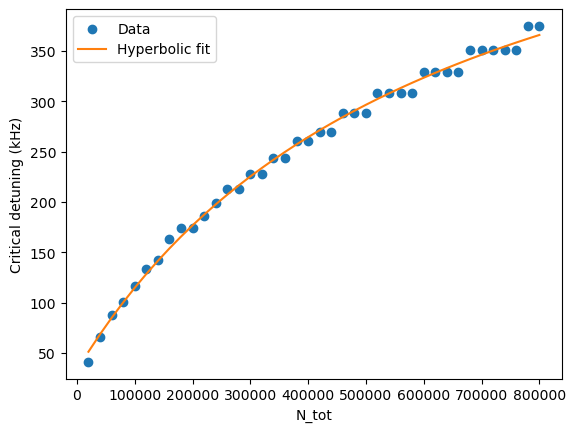

In [25]:
plt.scatter(N_tot_range, delta_crit, label="Data")
# plt.plot(N_tot_range, predict_Y_log(N_tot_range))
# plt.plot(N_tot_range, predict_Y_quad(N_tot_range))
plt.plot(N_tot_range, predict_Y_hyp(N_tot_range),label="Hyperbolic fit", color="#ff7f0e")
plt.ylabel("Critical detuning (kHz)")
plt.xlabel("N_tot")
plt.legend()
# delta_crit
# plt.scatter(N_tot_range, delta_crit)
# plt.plot(N_tot_range, predict_Y(N_tot_range))

In [26]:
predict_Y_hyp(5000)

37.42552693695268

In [18]:
import numpy as np
#from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

X = np.array(N_tot_range)
Y = np.array(delta_crit)

def quadratic_function(X, a, b, c):
    return a * X ** 2 + b * X + c

def logarithmic_function(X, a, b) :
    return a * np.log(X) + b

def hyperbola_function(x, a, b, c):
    return a / (x - b) + c

log_co, _ = curve_fit(logarithmic_function, X, Y)
quad_co, _ = curve_fit(quadratic_function, X, Y)
hyp_co, _ = curve_fit(hyperbola_function, X, Y)

print("Optimized parameters (log):", log_co)
print("Optimized parameters (quad):", quad_co)
print("Optimized parameters (hyper):", hyp_co)

def predict_Y_log(X):
    return logarithmic_function(X, *log_co)

def predict_Y_quad(X):
    return quadratic_function(X, *quad_co)

def predict_Y_hyp(X):
    return hyperbola_function(X, *hyp_co)

#print("R-squared:", r2_score(Y, predict_Y(X)))


Optimized parameters (log): [  101.74139845 -1039.89907725]
Optimized parameters (quad): [-3.61048609e-10  6.77617082e-04  5.04131583e+01]
Optimized parameters (hyper): [-3.70265609e+08 -6.24089004e+05  6.25999809e+02]


# Analyze & Plot
todo:  import util functions return predict Td
write block to plot with Td and found Td

In [ ]:
#############################################################
# Read in the results file
# Returns: 
#         [0]: time steps
#         [1]: sz
#         [2]: coherence
#         [3]: photons
#############################################################
results = []
detunings = []
for i in range(np.size(handle_list)):
    results.append(utils.read_results(handle_list[i])) # Input: file handle
    detunings.append(det_dict[handle_list[i]])
# results = utils.read_results(handle_list[0]) # Input: file handle
print(detunings)

In [ ]:
#############################################################
# Plots intracavity field
#############################################################
for i in [0,6,7]:
    end_ind = utils.cut_time(results[0][0], -1)
    print(end_ind)
    plt.plot(results[i][0], results[i][3], label=[int(k) for k in detunings[i]])
plt.title("Intracavity photon", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\langle a^\dagger a\rangle$", fontsize=12)
plt.legend()

In [ ]:
# More code on diff photons
ada_03 = (results[3][3]-results[1][3])/results[1][3]*100
ada_13 = (results[5][3]-results[4][3])/results[4][3]*100
ada_23 = (results[7][3]-results[6][3])/results[6][3]*100
plt.plot(results[0][0], ada_13, label=r"[0,$\delta/3$, $\delta$]-[0,$\delta/2$]")
plt.plot(results[0][0], ada_03, label=r"[0,$\delta/2$, $\delta$]-[0,$\delta/3$]")
plt.plot(results[0][0], ada_23, label=r"[0,$2\delta/3$, $\delta$]-[0,$2\delta/3$]")
plt.title("Intracavity photon difference", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\Delta\langle a^\dagger a\rangle (\%)$", fontsize=12)
plt.legend()

In [ ]:
#############################################################
# Line plots for inversion and coherence
#############################################################
for i in [0,4,5]:
    if len(detunings[i])<2:
        plt.plot(results[i][0], results[i][1], label=int(detunings[i]))
    else:
        plt.plot(results[i][0], results[i][1][:,0], label=[int(k) for k in detunings[i]])

# Td = utils.findTd(results[0][1], results[0][0])
# print(Td)
plt.title("Atomic inversion (1st class)", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\langle \sigma_Z \rangle$", fontsize=12)
plt.legend()

In [ ]:
# The main emission part
sz_03 = results[0][1][:,0]
sz_13 = results[4][1][:,0]
sz_23 = results[5][1][:,0]
plt.plot(results[0][0], sz_03, label=r"[0,$\delta$]")
plt.plot(results[0][0], sz_13, label=r"[0,$\delta/3$]")
plt.plot(results[0][0], sz_23, label=r"[0,$\delta/3$, $\delta$]")

# Td = utils.findTd(results[0][1], results[0][0])
# print(Td)
plt.title("Atomic inversion (1st class)", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\langle \sigma_Z \rangle$", fontsize=12)
plt.legend()

In [ ]:
sz_03 = (results[3][1][:,0]-results[1][1][:,0])
sz_13 = (results[5][1][:,0]-results[4][1][:,0])
sz_23 = (results[7][1][:,0]-results[6][1][:,0])
plt.plot(results[0][0], sz_13, label=r"[0,$\delta/3$, $\delta$]-[0,$\delta/3$]")
plt.plot(results[0][0], sz_03, label=r"[0,$\delta/2$, $\delta$]-[0,$\delta/2$]")
plt.plot(results[0][0], sz_23, label=r"[0,$2\delta/3$, $\delta$]-[0,$2\delta/3$]")

# Td = utils.findTd(results[0][1], results[0][0])
# print(Td)
plt.title("Atomic inversion (1st class)", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\Delta\langle \sigma_Z \rangle$", fontsize=12)
plt.legend()

In [ ]:
#############################################################
# Line plots for coherence
#############################################################
for i in [5,3,7]:
    if len(detunings[i])<3:
        plt.plot(results[i][0], results[i][2], label=int(detunings[i]))
    else:
        plt.plot(results[i][0], results[i][2][:,2], label=[int(k) for k in detunings[i]])

plt.title("Coherence", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\langle \sigma_+^k\sigma_-^0 \rangle$", fontsize=12)
plt.legend()

In [ ]:
utils.plot_heat(results[0],detuning_values_1d[:20], np.rot90(results[1]), -1.0,1.0, 
                "Atom inversion $\langle\sigma_Z\\rangle$", "Time ($\mu$s)", "Detuning (kHz)")

In [ ]:
utils.plot_heat(results[0],detuning_values_1d, np.rot90(results[2]), 0,0.25, 
                "Coherences", "Time ($\mu$s)", "$\langle\sigma_+\sigma_-\\rangle$")

In [ ]:

a = np.rot90(np.asarray([[0,1,2],[3,4,5]]))
print(a)
utils.plot_heat([0,1], [3,2,1], a, 0,6, "na", "na", "na")